## Team members 
1. Sai Hruthik Gangapuram 
2. Sujith Kumar Gajarla

# Task 1: Importing packages

In [ ]:
!pip install segmentation_models_pytorch

In [1]:
import sys
import cv2
import torch
import torchvision
import numpy as np 
import pandas as pd
from torch import nn
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split

# Task 2: Setup Configurations

In [2]:
sys.path.append('\Deep learning project final')
DEVICE = 'cuda'
IMAGE_HEIGHT = 320
IMAGE_WIDTH = 320
BATCH_SIZE = 8
ENCODER = 'efficientnet-b7'
WEIGHTS = 'imagenet'

In [3]:
data_frame = pd.read_csv('train.csv')
data_frame.head()

masks                    images
0    white masked images\0.png    training samples\0.jpg
1    white masked images\1.png    training samples\1.jpg
2   white masked images\10.png   training samples\10.jpg
3  white masked images\100.png  training samples\100.jpg
4  white masked images\101.png  training samples\101.jpg

In [4]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   masks   145 non-null    object
 1   images  145 non-null    object
dtypes: object(2)
memory usage: 2.4+ KB


# Task 3: Defining visulization functions

In [5]:
def mask_to_rgb(mask):
    color_map={
        0: (0, 0, 0), # Background
        1: (255, 0, 0), # Class 1
        2: (0, 255, 0), # Class 2
        3: (0, 0, 255), # Class 3
        4: (0, 128, 128), # Class 4
        5: (128, 0, 128), # Class 5
    }
    if isinstance(mask, torch.Tensor):
        mask = mask.detach().cpu().numpy()
    
    # Count the number of occurrences of each RGB color in the predicted mask.
    counts = {}
    for row in range(320):
        for column in range(320):
            class_index = mask[0][row][column]
            if class_index != 0:
                rgb = color_map[class_index]
                if rgb in counts:
                    counts[rgb] += 1
                else:
                    counts[rgb] = 1
                    
    # Determine the RGB color with the highest count that is not the background color.
    max_count = 0
    max_rgb = None
    for rgb, count in counts.items():
        if count > max_count and rgb != (0,0,0):
            max_count = count
            max_rgb = rgb
    
    # Replace all non-background class indexes in the mask with the chosen RGB color.
    if max_rgb is not None:
        rgb_mask = np.zeros((320, 320, 3), dtype=np.uint8)
        for row in range(320):
            for column in range(320):
                class_index = mask[0][row][column]
                if class_index != 0:
                    rgb = color_map[class_index]
                    if rgb == max_rgb:
                        rgb_mask[row][column] = rgb
                    else:
                        rgb_mask[row][column] = max_rgb
                else:
                    rgb_mask[row][column] = (0,0,0)
    else:
        # If all non-background colors have zero occurrences, use the original function.
        rgb_mask = np.zeros((320, 320, 3), dtype=np.uint8)
        for row in range(320):
            for column in range(320):
                class_index = mask[0][row][column]
                rgb_mask[row][column] = color_map[class_index]
                
    return rgb_mask


def show_image(image, mask, pred_image=None):
    image = image.permute(1, 2, 0).squeeze().numpy()
    mask = mask_to_rgb(mask)

    if pred_image is not None:
        pred_image = mask_to_rgb(pred_image)

    image = image / np.max(image)
    mask = mask / np.max(mask)
    
    if pred_image is not None:
        pred_image = pred_image / np.max(pred_image)

    if pred_image is None:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

        ax1.set_title('IMAGE')
        ax1.imshow(image, cmap='gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask)

    else:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

        ax1.set_title('IMAGE')
        ax1.imshow(image, cmap='gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask)

        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image)

    plt.show()

        
def classIndexMask(mask):
    # Define a dictionary mapping RGB color values to class indices
    color_to_class = {
      (0, 0, 0): 0,  # Black pixel represents background
      (255, 0, 0): 1,  # Red pixel represents Horse
      (0, 255, 0): 2,  # Green pixel represents Bench
      (0, 0, 255): 3,  # Blue pixel represents Water dispenser
      (0, 128, 128): 4,  # Blue pixel represents Stop sign
      (128, 0, 128): 5,  # Blue pixel represents Dust bin
    }

    # Load a masked image in RGB format
    mask_image = Image.open(mask)
    mask_image = mask_image.resize((320, 320))

    # Convert the RGB image to a numpy array
    mask_array = np.array(mask_image)

    # Create a new numpy array to hold the class index mask
    class_indices = np.zeros((mask_array.shape[0], mask_array.shape[1]), dtype=np.uint8)

    # Iterate over each RGB color value and map it to a class index
    for color, class_idx in color_to_class.items():
      # Find the indices in the numpy array where the RGB color value matches the dictionary key
      color_indices = np.where(np.all(mask_array == color, axis=-1))
      # Assign the corresponding class index to the pixels at those indices
      class_indices[color_indices] = class_idx
    return class_indices

Image Size (320, 320, 3)
Mask Size (320, 320, 3)


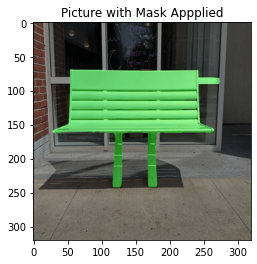

In [8]:
row = data_frame.iloc[39]
img = Image.open(row.images)
mask = Image.open(row.masks)
mask_np = np.array(mask)
mask_np_gray = cv2.cvtColor(mask_np, cv2.COLOR_RGB2GRAY).copy()

new_size = (320, 320)
img = img.resize(new_size)
mask = mask.resize(new_size)

print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)
plt.imshow(img)
plt.imshow(mask, alpha=0.4)
plt.title('Picture with Mask Applied')
plt.show()

# Task 4: Spliting the dataset into training | testing| validation

In [9]:
training_data, testing_data = train_test_split(data_frame, test_size=0.2, random_state=42)

validation_data, test_data = train_test_split(testing_data, test_size=0.5, random_state=42)

# Task 5 : Create Custom Dataset 

In [10]:
class SegmentationDataset(Dataset):
    
    def __init__(self, df):
        
        self.df=df
        self.transforms = transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT))
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self ,idx):
        row = self.df.iloc[idx]
        image_path = row['images']
        mask_path = row['masks']
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = classIndexMask(mask_path)
        mask =np.expand_dims(mask ,axis=-1)#(h,w,1)
        #(h,w,c) -> (c,h,w)
        image = np.transpose(image ,(2,0,1)).astype(np.float32)
        mask = np.transpose(mask ,(2,0,1)).astype(np.float32)
        original_image = self.transforms(torch.Tensor(image))
        original_image = original_image/255.0 # normalizing original image tensor [0,1] range
        return original_image, torch.Tensor(mask)

In [11]:
train_data_set = SegmentationDataset(training_data)
valid_data_set = SegmentationDataset(validation_data)
test_data_set = SegmentationDataset(test_data)

In [12]:
print('Size of Training dataset: {}'.format(train_data_set.__len__()))
print('Size of Testing dataset: {}'.format(test_data_set.__len__()))
print('Size of Validation dataset: {}'.format(valid_data_set.__len__()))

Size of Training dataset: 116
Size of Testing dataset: 15
Size of Validation dataset: 14


# Task 6: Loading dataset into Batches

In [13]:
train_loader = DataLoader(train_data_set, batch_size=8, shuffle=True)

val_loader = DataLoader(valid_data_set, batch_size=8, shuffle=True)

test_loader = DataLoader(test_data_set, batch_size=8, shuffle=True)

In [14]:
print('Total number of batches in train data loader: {}'.format(len(train_loader)))
print('Total number of batches in test data loader: {}'.format(len(test_loader)))
print('Total number of batches in validation data loader: {}'.format(len(val_loader)))

Total number of batches in train data loader: 15
Total number of batches in test data loader: 2
Total number of batches in validation data loader: 2


# Task 7: Visualising 1st sample in each batch

In [15]:
for image , mask in train_loader:
    break
print (f'One batch image shape: {image.shape}')
print (f'One batch image shape: {mask.shape}')

One batch image shape: torch.Size([8, 3, 320, 320])
One batch image shape: torch.Size([8, 1, 320, 320])


### Train data loader

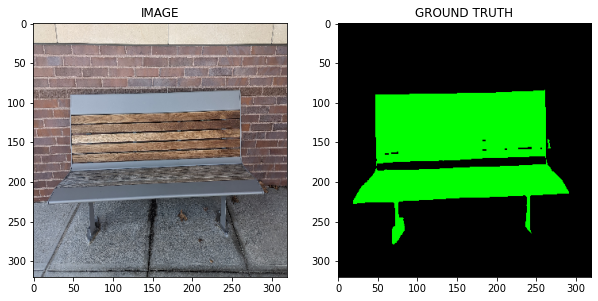

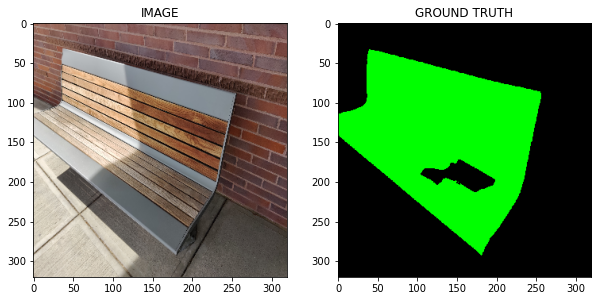

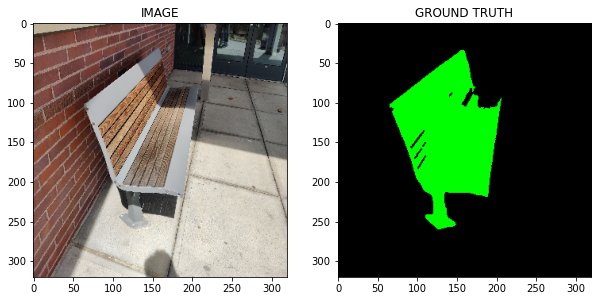

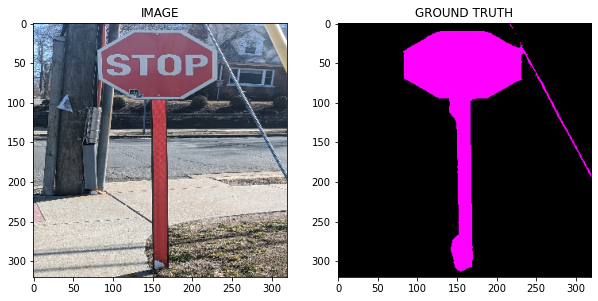

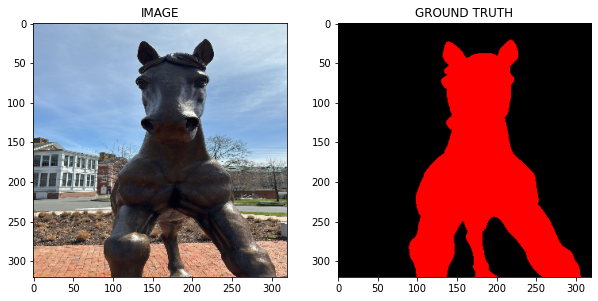

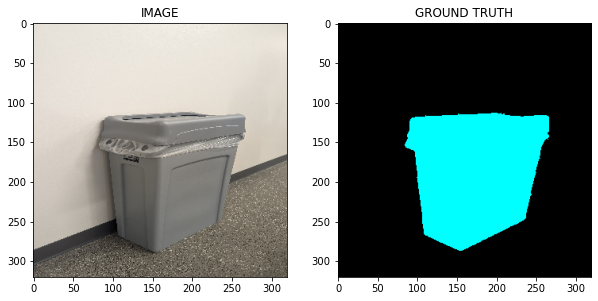

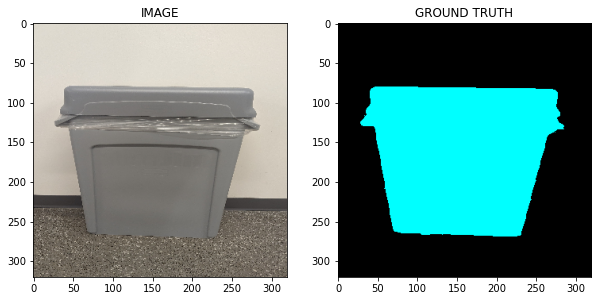

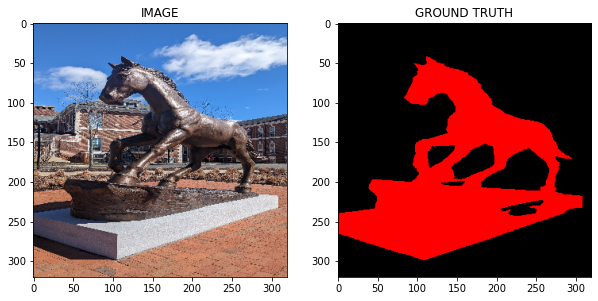

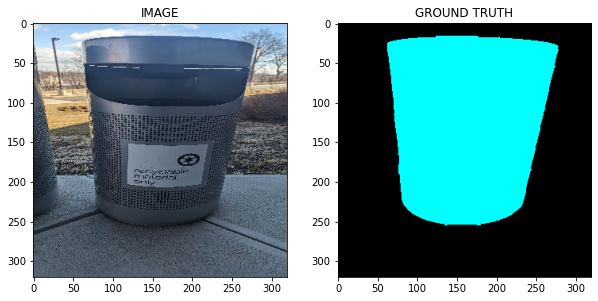

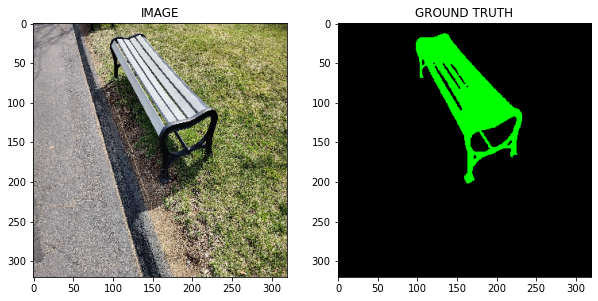

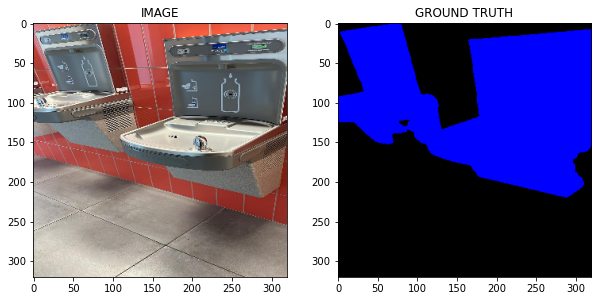

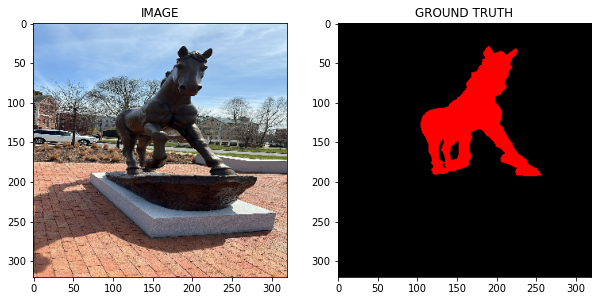

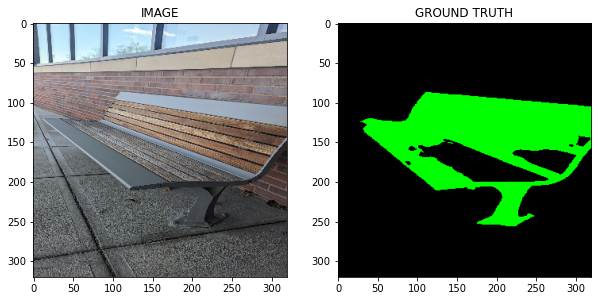

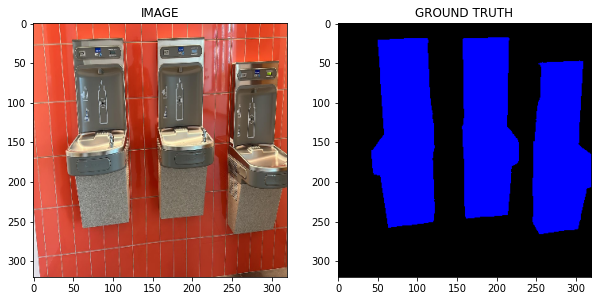

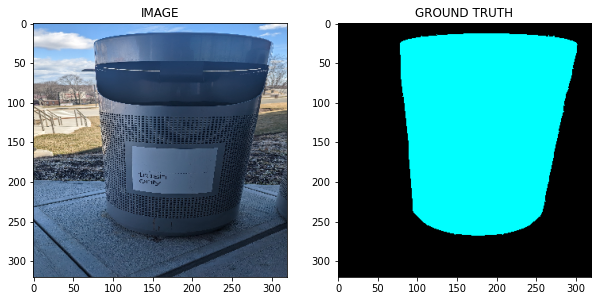

In [17]:
for batch_idx, (Original_images, Masked_images) in enumerate(train_loader):
    original_image = Original_images[0]
    masked_image = Masked_images[0]
    show_image(original_image, masked_image)

### Test data loader

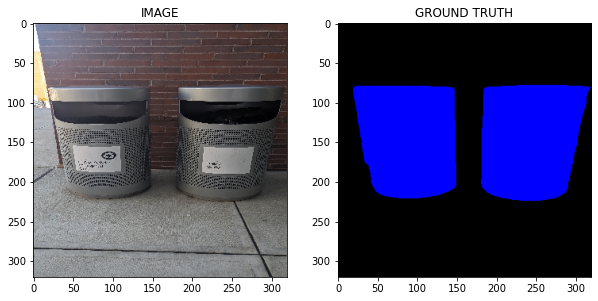

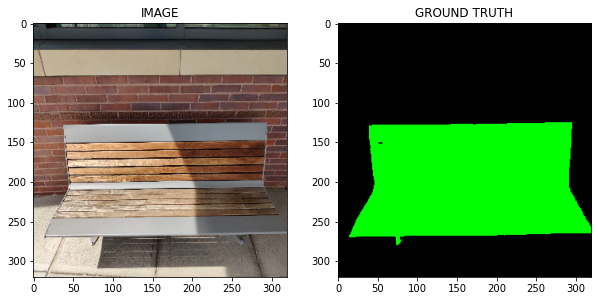

In [18]:
for batch_idx, (Original_images, Masked_images) in enumerate(test_loader):
    original_image = Original_images[0]
    masked_image = Masked_images[0]
    show_image(original_image, masked_image)

### Validation data loader

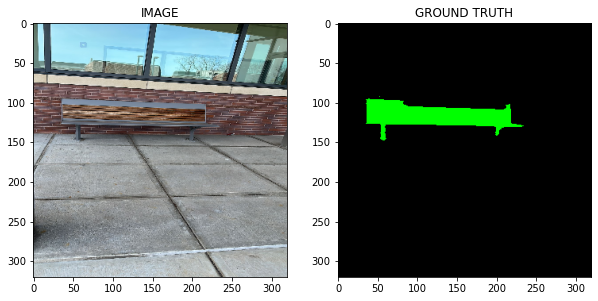

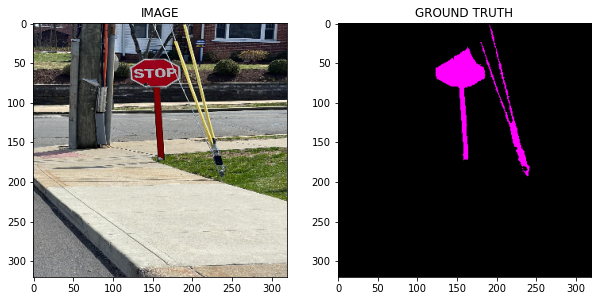

In [19]:
for batch_idx, (Original_images, Masked_images) in enumerate(val_loader):
    original_image = Original_images[0]
    masked_image = Masked_images[0]
    show_image(original_image, masked_image)

# Task 8 : Loading Pre-Trained Segmentation Model

In [20]:
class SegmentationModel (nn.Module):
    def __init__(self):
        super (SegmentationModel , self).__init__()

        self.arc = smp.Unet(
            encoder_name= ENCODER , # loading pre-trained model
            encoder_weights=  WEIGHTS , # loading pre-trained weights
            in_channels= 3 ,
            classes=  6, # (we have 6 classes including background)
            activation = 'softmax'
        )
        
        
    def forward(self, images, masks=None):
        logits = self.arc(images)

        if masks is not None:
            masks = masks.squeeze(1) # remove the channel dimension
            criterion = nn.CrossEntropyLoss()
            loss = criterion(logits, masks)
            return logits, loss

        return logits

In [21]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
      )
      (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
            (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
          )
          (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            64, 16, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            16, 64, kernel_size=(1, 1), strid

# Task 9: Training and validation

In [22]:
def train_fn(data_loader, model, optimizer):
    model.train()
    total_loss = 0
    tk0 = tqdm(data_loader, total=len(data_loader))
    for i, (images, masks) in enumerate(tk0):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        masks = masks.long()  # Convert to integer tensor
        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.mean().backward()
        optimizer.step()
        total_loss += loss.item()
        tk0.set_postfix(loss=total_loss/(i+1))
    return total_loss / len(data_loader)

def eval_fn(data_loader, model):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        tk0 = tqdm(data_loader, total=len(data_loader))
        for i, (images, masks) in enumerate(tk0):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            masks = masks.long()  # Convert to integer tensor
            logits, loss = model(images, masks)
            total_loss += loss.item()
            tk0.set_postfix(loss=total_loss/(i+1))
    return total_loss / len(data_loader)


# Task 10: Defining an Optimizer

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

### Model training is done in Google colab so below particular cell is not executed again in our own laptop due to the overlaod on the laptop 

In [ ]:
best_valid_loss = 1000
for i in range(50):
    train_loss = train_fn(trainloader , model , optimizer)
    valid_loss = eval_fn(validloader , model )

    if valid_loss< best_valid_loss :
        torch.save(model.state_dict(), 'bestModelAlpha.pt')
        print ("SAVED")
        best_valid_loss = valid_loss
    print(f"Epoch : {i+1} train_loss :{train_loss} valid_loss :{valid_loss}")

### Here we are loading the model that we have created in colab

In [24]:
model.load_state_dict(torch.load('bestModelAlpha.pt'))

<All keys matched successfully>

# Task 11: Evaluation on Test data

In [25]:
def evaluate_test_data(index):
    image, mask = test_data_set[index]
    logits_mask = model(image.to(DEVICE).unsqueeze (0)) #(C, H, W) -> (1, C, H, W)
    print(logits_mask.shape)
    pred_mask_prob = torch.softmax(logits_mask, dim=1)  # (batch_size, num_classes, height, width)
    _, pred_mask = torch.max(pred_mask_prob, dim=1)  # (batch_size, height, width)
    show_image(image, mask, pred_mask)
    rgb_mask = mask_to_rgb(pred_mask)
    # Create an alpha mask where alpha=0 for background pixels and alpha=0.5 for all other pixels
    alpha_mask = np.where(np.all(rgb_mask == (0, 0, 0), axis=-1), 0, 0.9)
    # Create a new RGBA mask combining the RGB mask and alpha mask
    rgba_mask = np.concatenate([rgb_mask, alpha_mask[..., np.newaxis]], axis=-1)

    # Overlay the mask on the image
    plt.imshow(image.permute(1, 2, 0))
    plt.imshow(rgba_mask, alpha=0.5)
    plt.title("Picture with Predicted Mask Applied")
    plt.show()

torch.Size([1, 6, 320, 320])


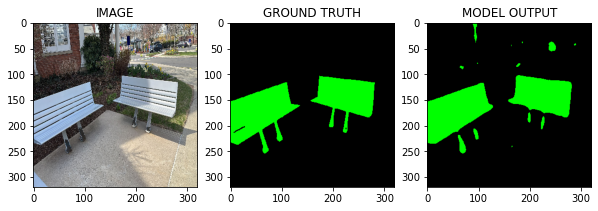

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


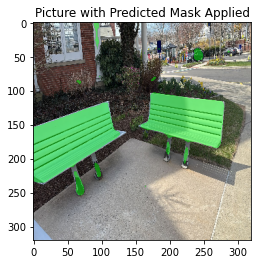

torch.Size([1, 6, 320, 320])


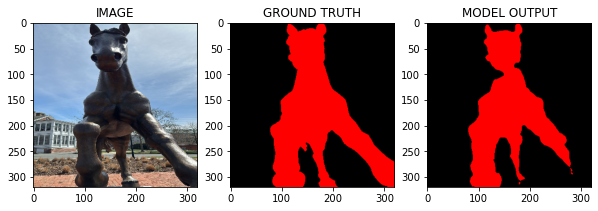

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


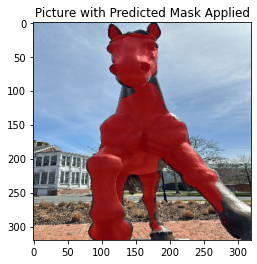

torch.Size([1, 6, 320, 320])


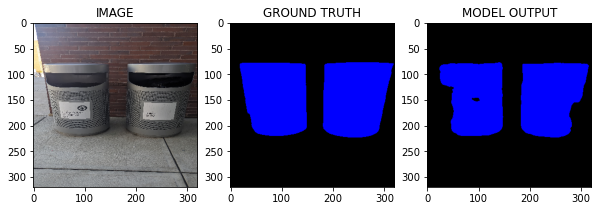

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


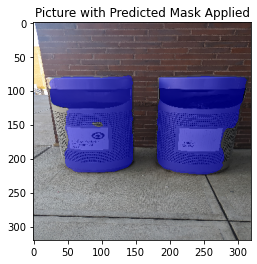

In [35]:
import random

for index in random.sample(list(range(len(test_data_set))), 3):
    evaluate_test_data(index)

<p><b>Intersection over Union (IoU)</b>: This is a widely used metric to evaluate the performance of a segmentation model. It measures the overlap between the predicted segmentation and the ground truth segmentation. IoU is defined as the area of intersection divided by the area of union between the predicted and ground truth segmentations. </p>

In [27]:
def normalize_list(lst):
    min_val = min(lst)
    max_val = max(lst)
    range_val = max_val - min_val
    normalized_lst = [(x - min_val) / range_val for x in lst]
    return normalized_lst

In [38]:
def calculate_iou(pred_masks, true_masks):
    iou_scores = []
    for i in range(len(pred_masks)):
        pred_mask = pred_masks[i].flatten()  # flatten the mask
        true_mask = true_masks[i].flatten()  # flatten the mask
        intersection = np.sum(pred_mask * true_mask)
        union = np.sum((pred_mask + true_mask) > 0)
        iou = intersection / union
        iou_scores.append(iou)
    normalized_iou_score = normalize_list(iou_scores)
    mean_iou = np.mean(normalized_iou_score)
    return mean_iou

In [39]:
pred_masks = []
true_masks = []
for i in range(len(test_data_set)):
    image, mask = test_data_set[i]
    logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(C, H, W) -> (1, C, H, W)
    print(logits_mask.shape)
    pred_mask_prob = torch.softmax(logits_mask, dim=1)  # (batch_size, num_classes, height, width)
    _, pred_mask = torch.max(pred_mask_prob, dim=1)  # (batch_size, height, width)
    
    pred_mask = pred_mask.detach().cpu().numpy()
    true_mask = mask.numpy()
    pred_masks.append(pred_mask)
    true_masks.append(true_mask)
mean_iou = calculate_iou(pred_masks, true_masks)

torch.Size([1, 6, 320, 320])
torch.Size([1, 6, 320, 320])
torch.Size([1, 6, 320, 320])
torch.Size([1, 6, 320, 320])
torch.Size([1, 6, 320, 320])
torch.Size([1, 6, 320, 320])
torch.Size([1, 6, 320, 320])
torch.Size([1, 6, 320, 320])
torch.Size([1, 6, 320, 320])
torch.Size([1, 6, 320, 320])
torch.Size([1, 6, 320, 320])
torch.Size([1, 6, 320, 320])
torch.Size([1, 6, 320, 320])
torch.Size([1, 6, 320, 320])
torch.Size([1, 6, 320, 320])


In [40]:
print('Mean Intersection over Unioin score is: {}'.format(mean_iou))

Mean Intersection over Unioin score is: 0.3887113452059166


# In general the IOU score lies in between 0 to 1 higher the score better the performance